In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import warnings
warnings.filterwarnings('ignore')



In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f"\nTraining samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Image shape: {train_dataset[0][0].shape}")


Training samples: 60000
Test samples: 10000
Image shape: torch.Size([1, 28, 28])


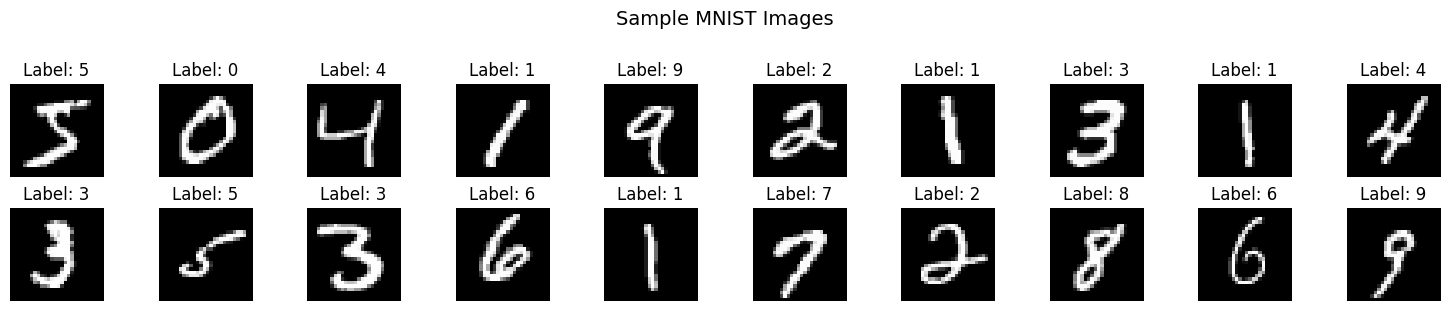

In [ ]:
# Display sample images
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
for i in range(20):
    ax = axes[i//10, i%10]
    img, label = train_dataset[i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')
plt.suptitle('Sample MNIST Images', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

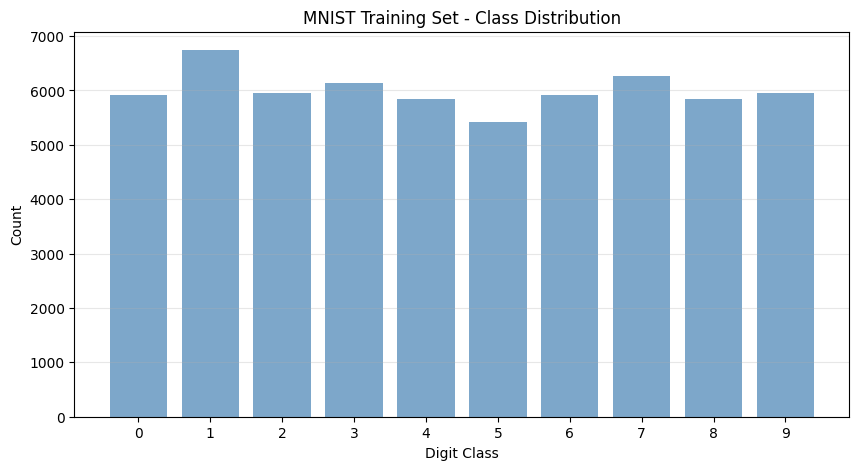

In [ ]:
# Class distribution
labels = [train_dataset[i][1] for i in range(len(train_dataset))]
unique, counts = np.unique(labels, return_counts=True)

plt.figure(figsize=(10, 5))
plt.bar(unique, counts, color='steelblue', alpha=0.7)
plt.xlabel('Digit Class')
plt.ylabel('Count')
plt.title('MNIST Training Set - Class Distribution')
plt.xticks(unique)
plt.grid(axis='y', alpha=0.3)
plt.show()

In [ ]:
class SuperResolutionAE(nn.Module):
    def __init__(self, latent_dim=64):
        super(SuperResolutionAE, self).__init__()

        # Encoder: 14x14 -> latent_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 7x7
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )

        # Decoder: latent_dim -> 28x28
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),  # 28x28
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        # Downsample input to 14x14
        x_down = nn.functional.interpolate(x, size=(14, 14), mode='bilinear', align_corners=False)
        z = self.encode(x_down)
        return self.decode(z)


In [ ]:
class ConvAE(nn.Module):
    """
    Convolutional Autoencoder - Fixed Version

    Architecture designed to properly encode and decode 28x28 MNIST images
    with symmetrical encoder-decoder structure.
    """
    def __init__(self, latent_dim=64):
        super(ConvAE, self).__init__()

        # Encoder: 28x28 -> latent_dim
        # Progressive downsampling with increasing channels
        self.encoder = nn.Sequential(
            # Layer 1: 28x28x1 -> 14x14x32
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            # Layer 2: 14x14x32 -> 7x7x64
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # Layer 3: 7x7x64 -> 7x7x128
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            # Flatten and compress to latent space
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, latent_dim)
        )

        # Decoder: latent_dim -> 28x28
        # Progressive upsampling with decreasing channels
        self.decoder = nn.Sequential(
            # Expand from latent space
            nn.Linear(latent_dim, 128 * 7 * 7),
            nn.ReLU(inplace=True),
            nn.Unflatten(1, (128, 7, 7)),

            # Layer 1: 7x7x128 -> 7x7x64
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # Layer 2: 7x7x64 -> 14x14x32
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            # Layer 3: 14x14x32 -> 28x28x1
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Output in [0, 1] range
        )

    def encode(self, x):
        """Encode input to latent representation"""
        return self.encoder(x)

    def decode(self, z):
        """Decode latent representation to reconstruction"""
        return self.decoder(z)

    def forward(self, x):
        """Full forward pass: encode then decode"""
        z = self.encode(x)
        return self.decode(z)

In [ ]:
class StackedAE(nn.Module):
    def __init__(self, latent_dim=64):
        super(StackedAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

In [ ]:
def train_autoencoder(model, train_loader, epochs=10, lr=0.001):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)

            # Forward pass
            reconstructed = model(data)
            loss = criterion(reconstructed, data)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}')

    return losses

In [ ]:
latent_dim = 64
epochs = 5

In [ ]:


print("=" * 50)
print("Training Super Resolution Autoencoder")
print("=" * 50)
sr_ae = SuperResolutionAE(latent_dim=latent_dim)
sr_losses = train_autoencoder(sr_ae, train_loader, epochs=epochs)


Training Super Resolution Autoencoder
Epoch [1/5], Loss: 0.073035
Epoch [2/5], Loss: 0.023038
Epoch [3/5], Loss: 0.013080
Epoch [4/5], Loss: 0.009680
Epoch [5/5], Loss: 0.008047


In [ ]:
print("\n" + "=" * 50)
print("Training Convolutional Autoencoder")
print("=" * 50)
conv_ae = ConvAE(latent_dim=latent_dim)
conv_losses = train_autoencoder(conv_ae, train_loader, epochs=epochs)




Training Convolutional Autoencoder
Epoch [1/5], Loss: 0.021365
Epoch [2/5], Loss: 0.003606
Epoch [3/5], Loss: 0.002735
Epoch [4/5], Loss: 0.002368
Epoch [5/5], Loss: 0.002153


In [ ]:
print("\n" + "=" * 50)
print("Training Stacked Autoencoder")
print("=" * 50)
stacked_ae = StackedAE(latent_dim=latent_dim)
stacked_losses = train_autoencoder(stacked_ae, train_loader, epochs=epochs)


Training Stacked Autoencoder
Epoch [1/5], Loss: 0.052365
Epoch [2/5], Loss: 0.026204
Epoch [3/5], Loss: 0.020585
Epoch [4/5], Loss: 0.017606
Epoch [5/5], Loss: 0.015532


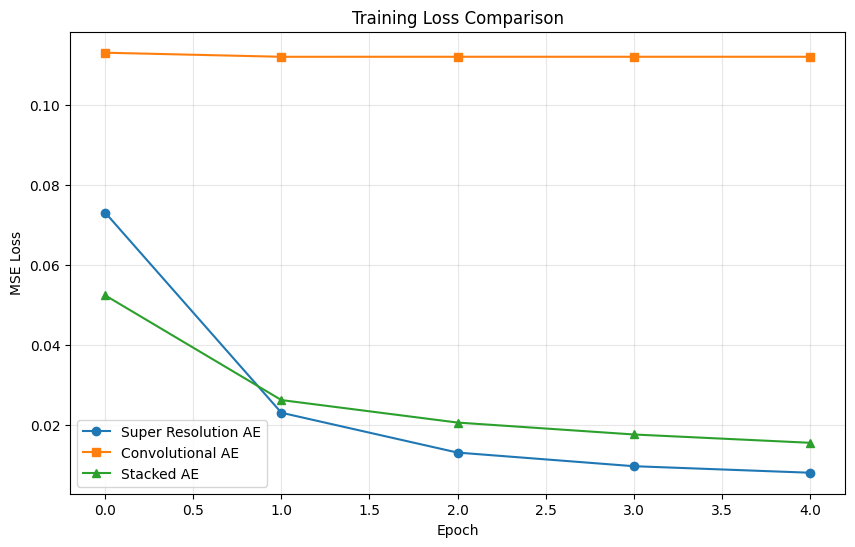

In [ ]:
# Plot training losses
plt.figure(figsize=(10, 6))
plt.plot(sr_losses, label='Super Resolution AE', marker='o')
plt.plot(conv_losses, label='Convolutional AE', marker='s')
plt.plot(stacked_losses, label='Stacked AE', marker='^')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [ ]:
def visualize_reconstructions(model, dataset, n_samples=10):
    model.eval()
    fig, axes = plt.subplots(2, n_samples, figsize=(15, 3))

    with torch.no_grad():
        for i in range(n_samples):
            img, label = dataset[i]
            img = img.unsqueeze(0).to(device)
            reconstructed = model(img).cpu()

            # Original
            axes[0, i].imshow(img.cpu().squeeze(), cmap='gray')
            axes[0, i].set_title(f'Orig: {label}')
            axes[0, i].axis('off')

            # Reconstructed
            axes[1, i].imshow(reconstructed.squeeze(), cmap='gray')
            axes[1, i].set_title('Recon')
            axes[1, i].axis('off')

    plt.tight_layout()
    return fig

Super Resolution Autoencoder Reconstructions


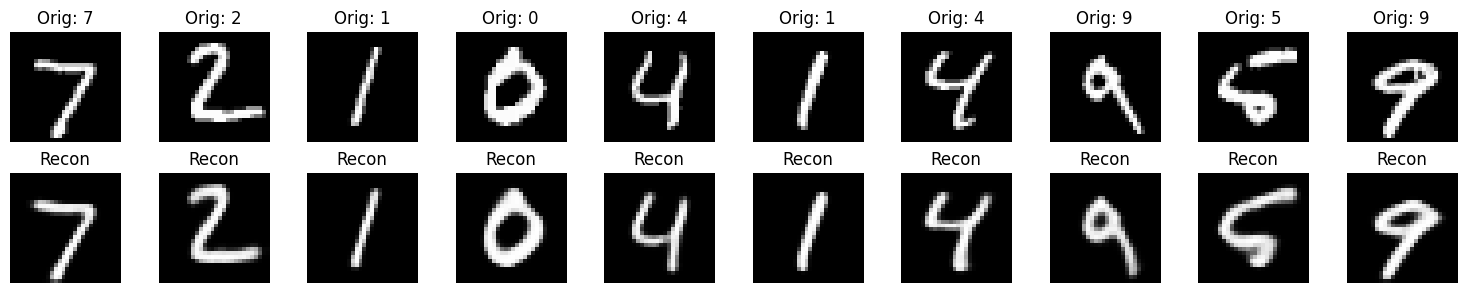

In [ ]:
print("Super Resolution Autoencoder Reconstructions")
visualize_reconstructions(sr_ae, test_dataset)
plt.show()


Convolutional Autoencoder Reconstructions


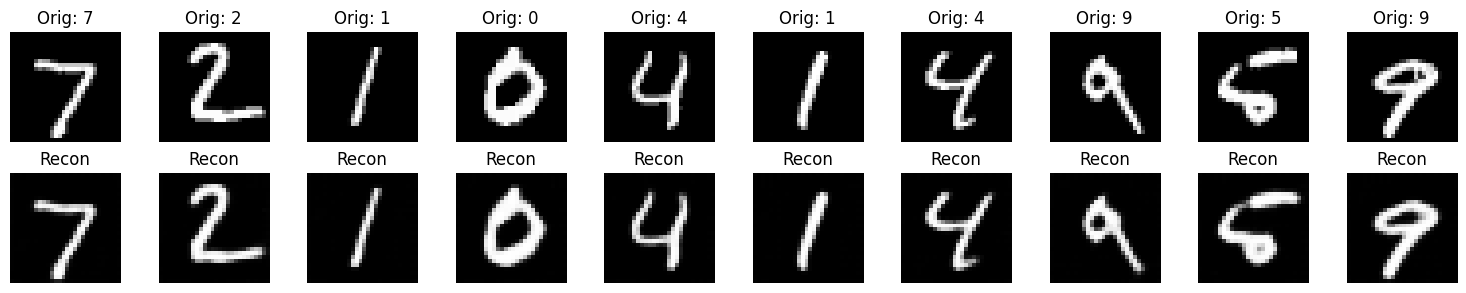

In [ ]:
print("\nConvolutional Autoencoder Reconstructions")
visualize_reconstructions(conv_ae, test_dataset)
plt.show()


Stacked Autoencoder Reconstructions


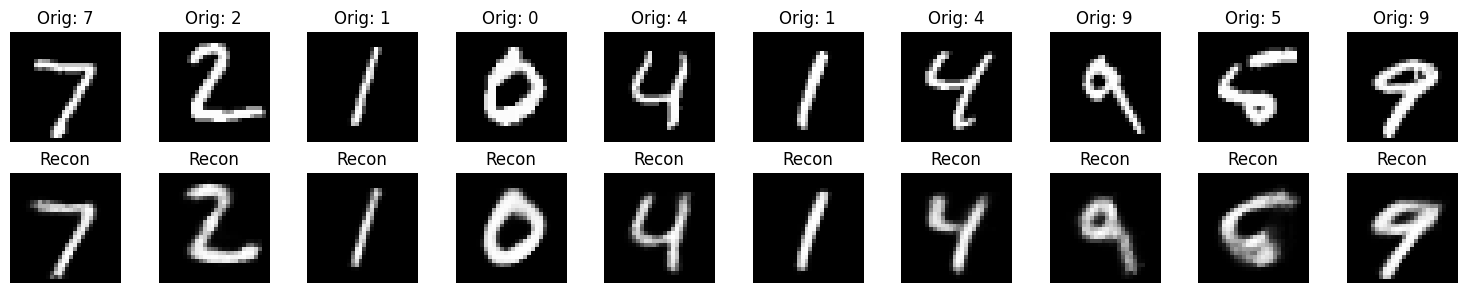

In [ ]:
print("\nStacked Autoencoder Reconstructions")
visualize_reconstructions(stacked_ae, test_dataset)
plt.show()

In [ ]:
def get_latent_representations(model, dataset, n_samples=20):
    model.eval()
    latents = []
    labels = []

    with torch.no_grad():
        for i in range(n_samples):
            img, label = dataset[i]
            img = img.unsqueeze(0).to(device)

            # Get latent representation
            if isinstance(model, SuperResolutionAE):
                # For SR-AE, downsample first
                img_down = nn.functional.interpolate(img, size=(14, 14), mode='bilinear', align_corners=False)
                z = model.encode(img_down).cpu().numpy()
            else:
                z = model.encode(img).cpu().numpy()

            latents.append(z)
            labels.append(label)

    return np.vstack(latents), np.array(labels)


In [ ]:
# Get latent representations for 20 samples
sr_latents_20, labels_20 = get_latent_representations(sr_ae, test_dataset, n_samples=20)
conv_latents_20, _ = get_latent_representations(conv_ae, test_dataset, n_samples=20)
stacked_latents_20, _ = get_latent_representations(stacked_ae, test_dataset, n_samples=20)

# Apply t-SNE for visualization (only if latent_dim > 2)
if latent_dim > 2:
    tsne = TSNE(n_components=2, random_state=42, perplexity=5)
    sr_2d = tsne.fit_transform(sr_latents_20)

    tsne = TSNE(n_components=2, random_state=42, perplexity=5)
    conv_2d = tsne.fit_transform(conv_latents_20)

    tsne = TSNE(n_components=2, random_state=42, perplexity=5)
    stacked_2d = tsne.fit_transform(stacked_latents_20)
else:
    sr_2d, conv_2d, stacked_2d = sr_latents_20, conv_latents_20, stacked_latents_20


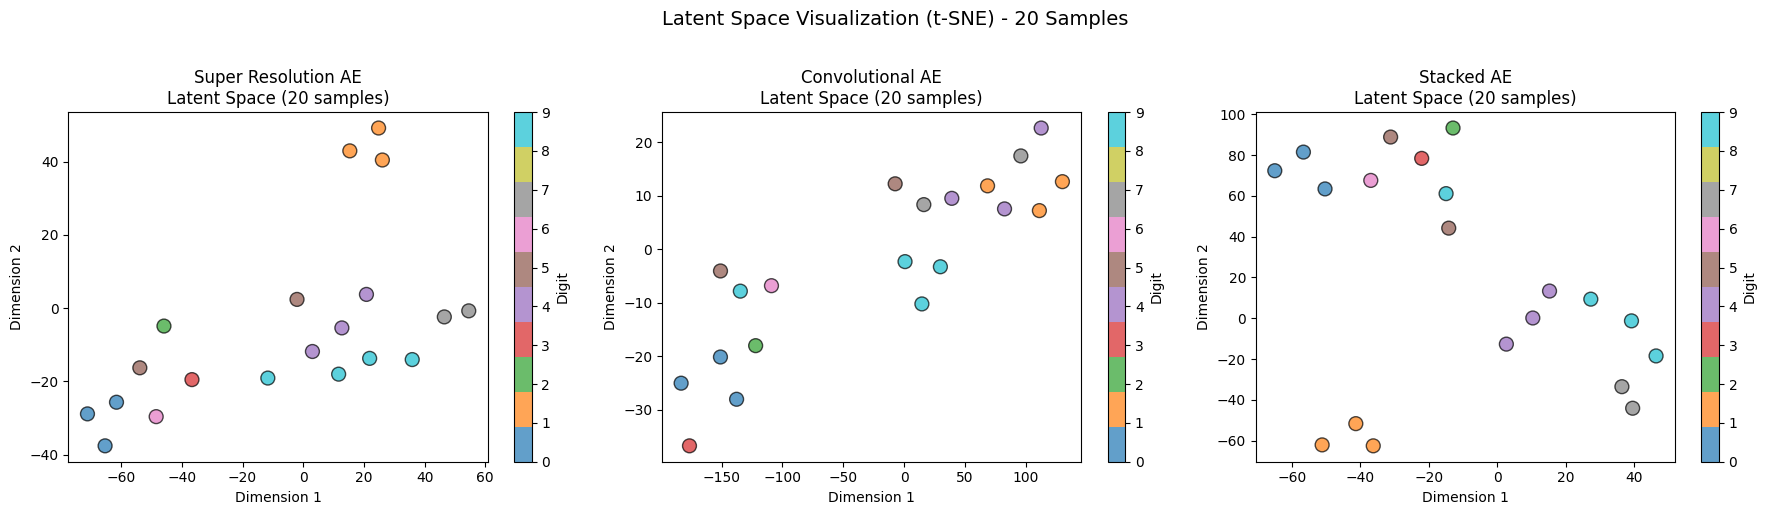

In [ ]:
# Plot 20-sample latent space
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

scatter1 = axes[0].scatter(sr_2d[:, 0], sr_2d[:, 1], c=labels_20, cmap='tab10', s=100, alpha=0.7, edgecolors='black')
axes[0].set_title('Super Resolution AE\nLatent Space (20 samples)', fontsize=12)
axes[0].set_xlabel('Dimension 1')
axes[0].set_ylabel('Dimension 2')
plt.colorbar(scatter1, ax=axes[0], label='Digit')

scatter2 = axes[1].scatter(conv_2d[:, 0], conv_2d[:, 1], c=labels_20, cmap='tab10', s=100, alpha=0.7, edgecolors='black')
axes[1].set_title('Convolutional AE\nLatent Space (20 samples)', fontsize=12)
axes[1].set_xlabel('Dimension 1')
axes[1].set_ylabel('Dimension 2')
plt.colorbar(scatter2, ax=axes[1], label='Digit')

scatter3 = axes[2].scatter(stacked_2d[:, 0], stacked_2d[:, 1], c=labels_20, cmap='tab10', s=100, alpha=0.7, edgecolors='black')
axes[2].set_title('Stacked AE\nLatent Space (20 samples)', fontsize=12)
axes[2].set_xlabel('Dimension 1')
axes[2].set_ylabel('Dimension 2')
plt.colorbar(scatter3, ax=axes[2], label='Digit')

plt.suptitle('Latent Space Visualization (t-SNE) - 20 Samples', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

Extracting latent representations for 20 samples per class...
Extracted 200 samples (should be 200)
Applying t-SNE dimensionality reduction...
t-SNE complete!


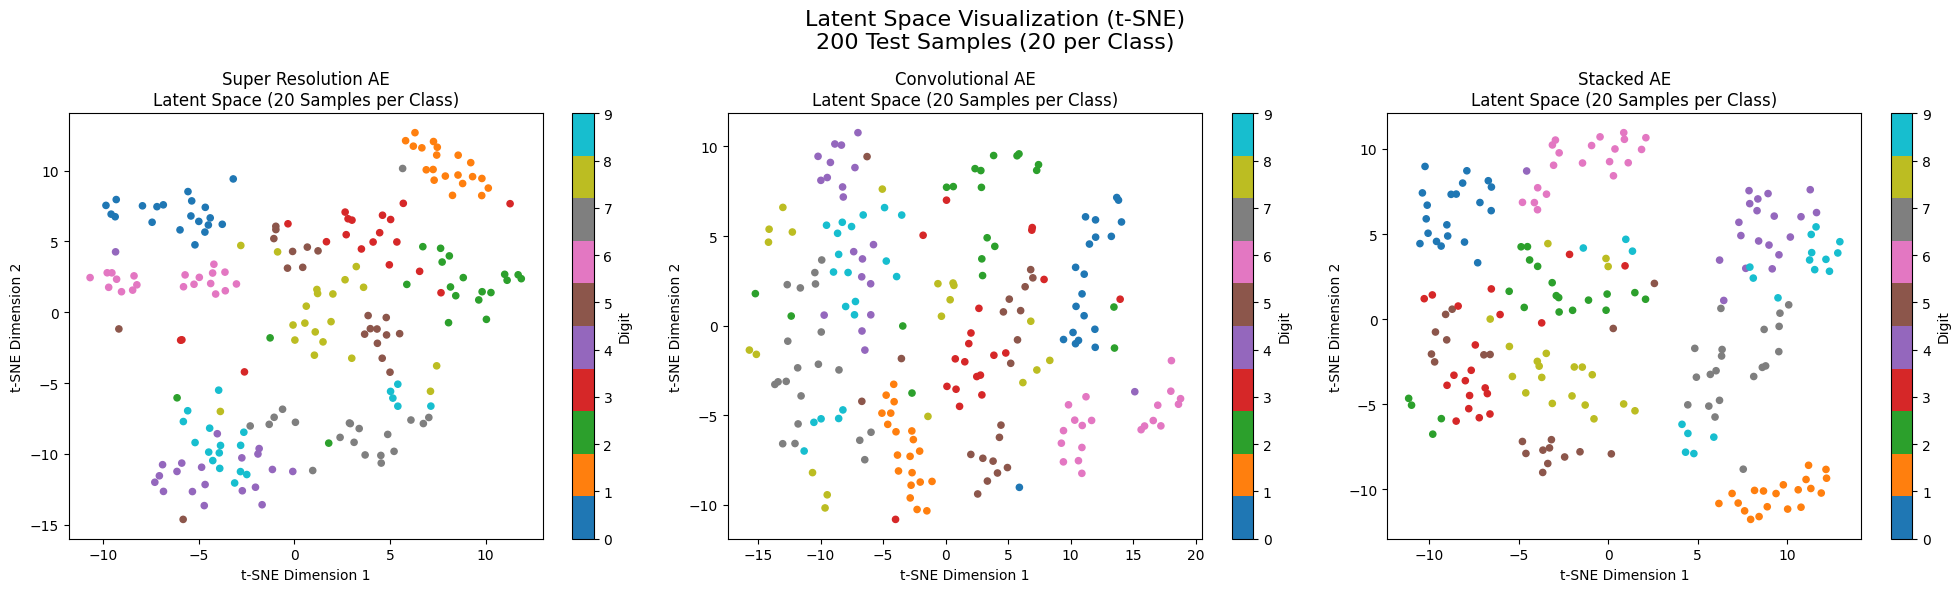

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Subset
from collections import defaultdict
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ============================
# 1. Select 20 samples per class
# ============================
def get_20_per_class(dataset, num_per_class=20):
    class_count = defaultdict(int)
    selected_indices = []

    for idx, (_, label) in enumerate(dataset):
        label = int(label)
        if class_count[label] < num_per_class:
            selected_indices.append(idx)
            class_count[label] += 1
        if len(selected_indices) == 10 * num_per_class:
            break

    return Subset(dataset, selected_indices)


# Create 20-per-class subset
test_subset = get_20_per_class(test_dataset, num_per_class=20)
subset_loader = DataLoader(test_subset, batch_size=64, shuffle=False)



# ============================
# 2. Extract latent representations
# ============================
def get_all_latent_representations(model, data_loader):
    model.eval()
    latents = []
    labels = []

    with torch.no_grad():
        for batch_data, batch_labels in data_loader:
            batch_data = batch_data.to(device)

            # Autoencoder encode logic
            if isinstance(model, SuperResolutionAE):
                batch_down = nn.functional.interpolate(batch_data, size=(14, 14), mode='bilinear', align_corners=False)
                z = model.encode(batch_down).cpu().numpy()
            else:
                z = model.encode(batch_data).cpu().numpy()

            latents.append(z)
            labels.append(batch_labels.numpy())

    return np.vstack(latents), np.concatenate(labels)



# Extract latent vectors from the 20-per-class subset
print("Extracting latent representations for 20 samples per class...")
sr_latents_all, labels_all = get_all_latent_representations(sr_ae, subset_loader)
conv_latents_all, _ = get_all_latent_representations(conv_ae, subset_loader)
stacked_latents_all, _ = get_all_latent_representations(stacked_ae, subset_loader)

print(f"Extracted {len(labels_all)} samples (should be 200)")


# ============================
# 3. Apply t-SNE
# ============================
print("Applying t-SNE dimensionality reduction...")

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
sr_2d_all = tsne.fit_transform(sr_latents_all)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
conv_2d_all = tsne.fit_transform(conv_latents_all)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
stacked_2d_all = tsne.fit_transform(stacked_latents_all)

print("t-SNE complete!")


# ============================
# 4. Plot results
# ============================
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

scatter1 = axes[0].scatter(sr_2d_all[:, 0], sr_2d_all[:, 1], c=labels_all, cmap='tab10', s=20)
axes[0].set_title('Super Resolution AE\nLatent Space (20 Samples per Class)')
axes[0].set_xlabel('t-SNE Dimension 1')
axes[0].set_ylabel('t-SNE Dimension 2')
plt.colorbar(scatter1, ax=axes[0], label='Digit')

scatter2 = axes[1].scatter(conv_2d_all[:, 0], conv_2d_all[:, 1], c=labels_all, cmap='tab10', s=20)
axes[1].set_title('Convolutional AE\nLatent Space (20 Samples per Class)')
axes[1].set_xlabel('t-SNE Dimension 1')
axes[1].set_ylabel('t-SNE Dimension 2')
plt.colorbar(scatter2, ax=axes[1], label='Digit')

scatter3 = axes[2].scatter(stacked_2d_all[:, 0], stacked_2d_all[:, 1], c=labels_all, cmap='tab10', s=20)
axes[2].set_title('Stacked AE\nLatent Space (20 Samples per Class)')
axes[2].set_xlabel('t-SNE Dimension 1')
axes[2].set_ylabel('t-SNE Dimension 2')
plt.colorbar(scatter3, ax=axes[2], label='Digit')

plt.suptitle('Latent Space Visualization (t-SNE)\n200 Test Samples (20 per Class)', fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# Calculate reconstruction errors
def calculate_reconstruction_error(model, data_loader):
    model.eval()
    mse_loss = nn.MSELoss()
    total_error = 0
    n_samples = 0

    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            reconstructed = model(data)
            error = mse_loss(reconstructed, data)
            total_error += error.item() * data.size(0)
            n_samples += data.size(0)

    return total_error / n_samples

sr_error = calculate_reconstruction_error(sr_ae, test_loader)
conv_error = calculate_reconstruction_error(conv_ae, test_loader)
stacked_error = calculate_reconstruction_error(stacked_ae, test_loader)

print("Test Set Reconstruction Errors:")
print(f"Super Resolution AE: {sr_error:.6f}")
print(f"Convolutional AE: {conv_error:.6f}")
print(f"Stacked AE: {stacked_error:.6f}")


Test Set Reconstruction Errors:
Super Resolution AE: 0.007407
Convolutional AE: 0.002096
Stacked AE: 0.014568


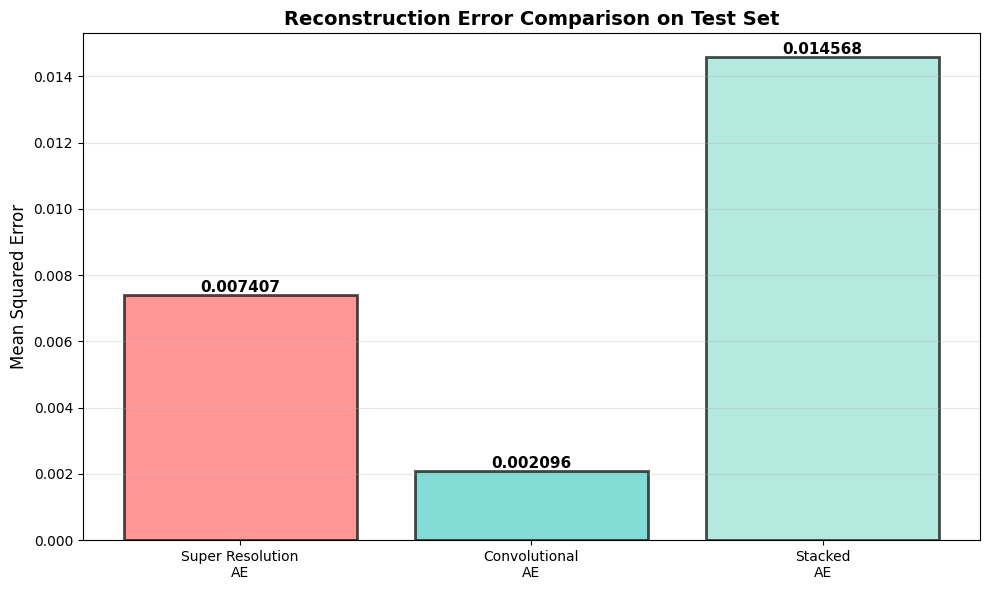

In [ ]:
# Bar plot comparison
fig, ax = plt.subplots(figsize=(10, 6))
models = ['Super Resolution\nAE', 'Convolutional\nAE', 'Stacked\nAE']
errors = [sr_error, conv_error, stacked_error]
colors = ['#FF6B6B', '#4ECDC4', '#95E1D3']

bars = ax.bar(models, errors, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Mean Squared Error', fontsize=12)
ax.set_title('Reconstruction Error Comparison on Test Set', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, error in zip(bars, errors):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{error:.6f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
### Cell 25 ###
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np


print("\n========================================")
print("Extracting full latent space for SVM...")
print("========================================")

# -----------------------------
# Extract latent vectors for ALL training data
# -----------------------------
train_latents = []
train_labels = []

conv_ae.eval()
with torch.no_grad():
    for batch_data, batch_labels in train_loader:
        batch_data = batch_data.to(device)
        z = conv_ae.encode(batch_data).cpu().numpy()
        train_latents.append(z)
        train_labels.append(batch_labels.numpy())

train_latents = np.vstack(train_latents)
train_labels = np.concatenate(train_labels)

print(f"Training latent vectors shape: {train_latents.shape}")


# -----------------------------
# Extract latent vectors for ALL test data
# -----------------------------
test_latents = []
test_labels = []

with torch.no_grad():
    for batch_data, batch_labels in test_loader:
        batch_data = batch_data.to(device)
        z = conv_ae.encode(batch_data).cpu().numpy()
        test_latents.append(z)
        test_labels.append(batch_labels.numpy())

test_latents = np.vstack(test_latents)
test_labels = np.concatenate(test_labels)

print(f"Test latent vectors shape: {test_latents.shape}")


# -----------------------------
# Train SVM classifier
# -----------------------------
print("\n========================================")
print("Training SVM Classifier on latent space...")
print("========================================")

svm = SVC(kernel='rbf', C=10, gamma='scale')
svm.fit(train_latents, train_labels)

print("SVM training complete!")


# -----------------------------
# Evaluate on test latent vectors
# -----------------------------
preds = svm.predict(test_latents)
accuracy = accuracy_score(test_labels, preds)

print("\n========================================")
print("SVM Classification Results (ConvAE latent space)")
print("========================================")
print(f"Test Accuracy: {accuracy*100:.2f}%")



Extracting full latent space for SVM...
Training latent vectors shape: (60000, 64)
Test latent vectors shape: (10000, 64)

Training SVM Classifier on latent space...
SVM training complete!

SVM Classification Results (ConvAE latent space)
Test Accuracy: 98.78%
